In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [4]:
# Load the dataset
data = pd.read_excel("D:/DATA ANALYTICS PROJECTS/PYTHON PROJECTS/Customer-Segmentation-using-Clustering-Algorithm/online+retail/Online Retail.xlsx")
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Check the column names to ensure 'InvoiceDate' is present
print("Column names:", data.columns)

# Display the first few rows to inspect the data structure
print(data.head())

Column names: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Sales'],
      dtype='object')
                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

                     Quantity  UnitPrice  CustomerID         Country  Sales  
InvoiceDate                                                                  
2010-12-01 08:26:00         6       2.55     17850.0  United Kingdom  15.30  
2010-12-01 08:26:00         6       3.39     17850.0  

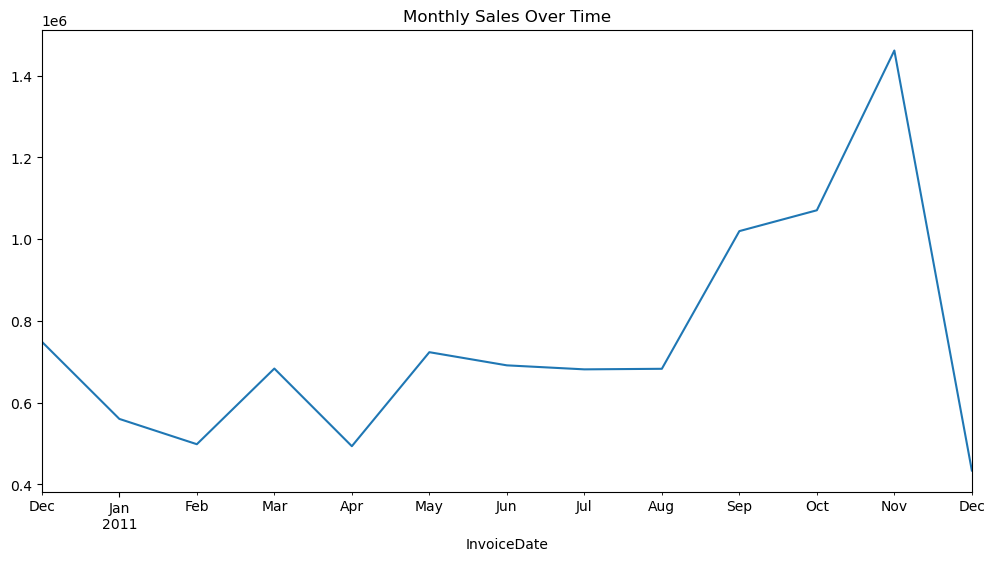

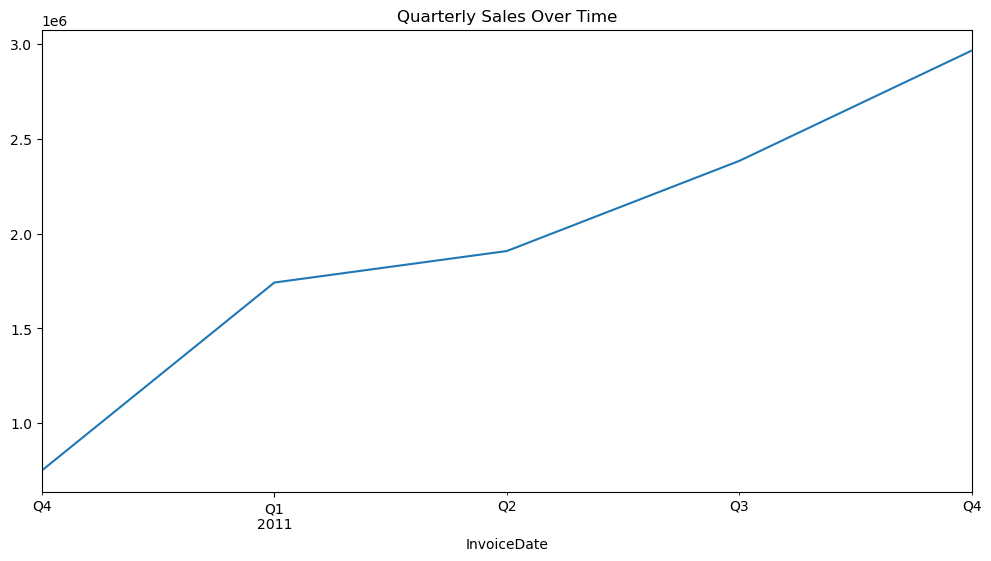

Not enough data for seasonal decomposition (requires at least 24 months).


In [11]:
# Ensure Quantity and UnitPrice are numeric, as before
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')

# Drop rows with NaN values in Quantity or UnitPrice after conversion
data.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)

# Recalculate Sales if needed
data['Sales'] = data['Quantity'] * data['UnitPrice']

# Monthly and Quarterly Sales
monthly_sales = data['Sales'].resample('M').sum()
quarterly_sales = data['Sales'].resample('Q').sum()

# Plotting
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot monthly sales
monthly_sales.plot(figsize=(12, 6), title="Monthly Sales Over Time")
plt.show()

# Plot quarterly sales
quarterly_sales.plot(figsize=(12, 6), title="Quarterly Sales Over Time")
plt.show()

# Seasonal decomposition for monthly sales (ensure enough data points)
if len(monthly_sales) >= 24:
    decomposition = seasonal_decompose(monthly_sales, model='additive')
    decomposition.plot()
    plt.show()
else:
    print("Not enough data for seasonal decomposition (requires at least 24 months).")


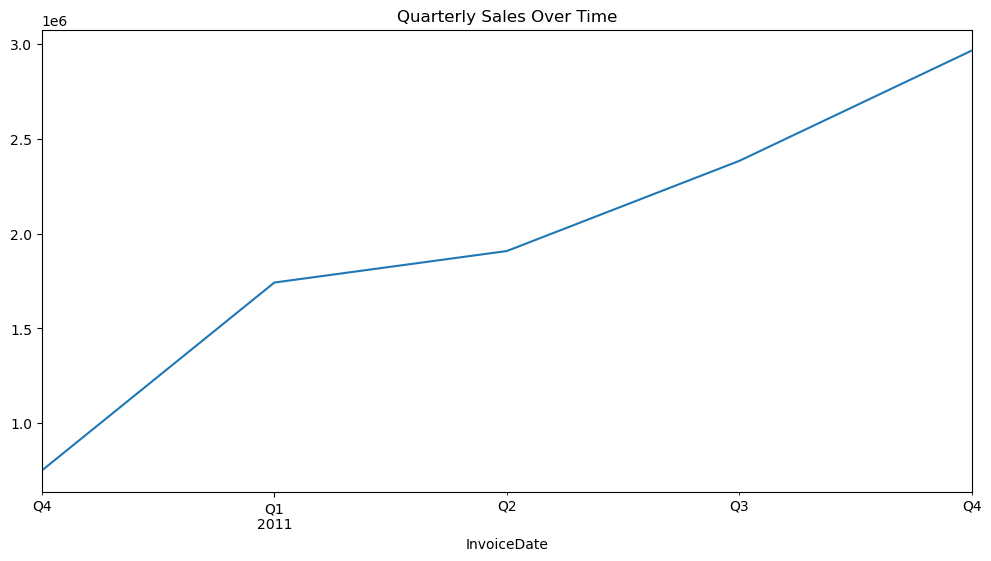

In [13]:
# Plot quarterly sales even without seasonal decomposition
quarterly_sales.plot(figsize=(12, 6), title="Quarterly Sales Over Time")
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

# Differencing the series if needed
diff_series = monthly_sales.diff().dropna()

# ADF test
adf_test = adfuller(diff_series)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -4.1063043397786085
p-value: 0.0009455445431999263


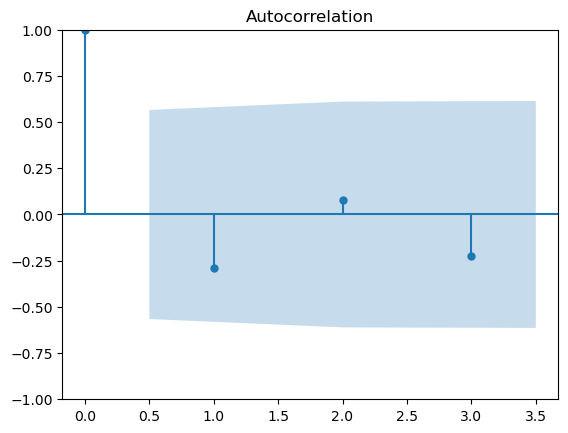

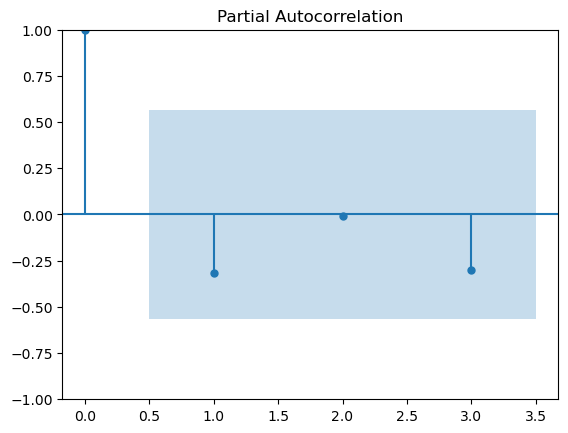

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -168.452
Date:                Thu, 07 Nov 2024   AIC                            342.904
Time:                        10:31:56   BIC                            344.359
Sample:                    12-31-2010   HQIC                           342.366
                         - 12-31-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3040      1.088     -0.279      0.780      -2.437       1.829
ma.L1         -0.4566      0.695     -0.657      0.511      -1.819       0.906
sigma2      1.086e+11   7.95e-12   1.37e+22      0.0

C:\Users\dashp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots with a reduced number of lags
plot_acf(diff_series, lags=3)  # Set to an appropriate value
plot_pacf(diff_series, lags=3)  # Same for PACF
plt.show()

from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1, 1, 1  # Example values, adjust based on ACF/PACF analysis

# Define and fit the ARIMA model
model = ARIMA(monthly_sales, order=(p, d, q))
model_fit = model.fit()

# Check the model summary
print(model_fit.summary())

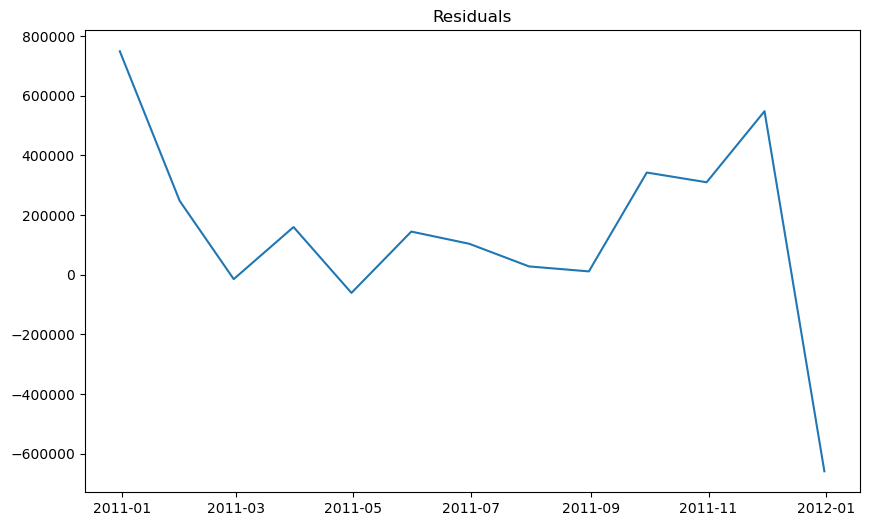

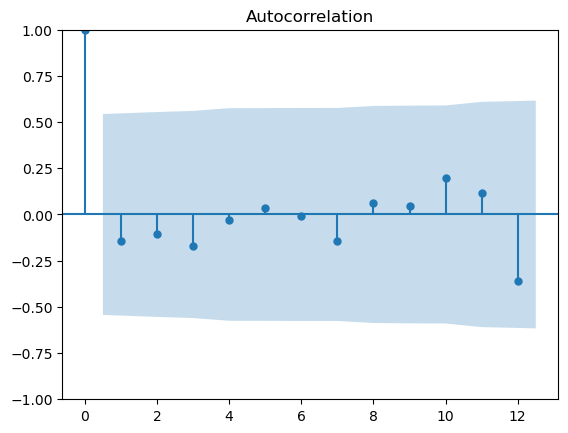

Ljung-Box Test (Residuals) p-value: 0.9139332466061867


In [21]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

# Plot ACF of residuals to check for autocorrelation
plot_acf(residuals)
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test on residuals
ljung_box = acorr_ljungbox(residuals, lags=[10])

# Extract the p-value for the Ljung-Box test
p_value = ljung_box['lb_pvalue'].iloc[0]  # Use iloc[0] to access the first row's p-value
print(f"Ljung-Box Test (Residuals) p-value: {p_value}")


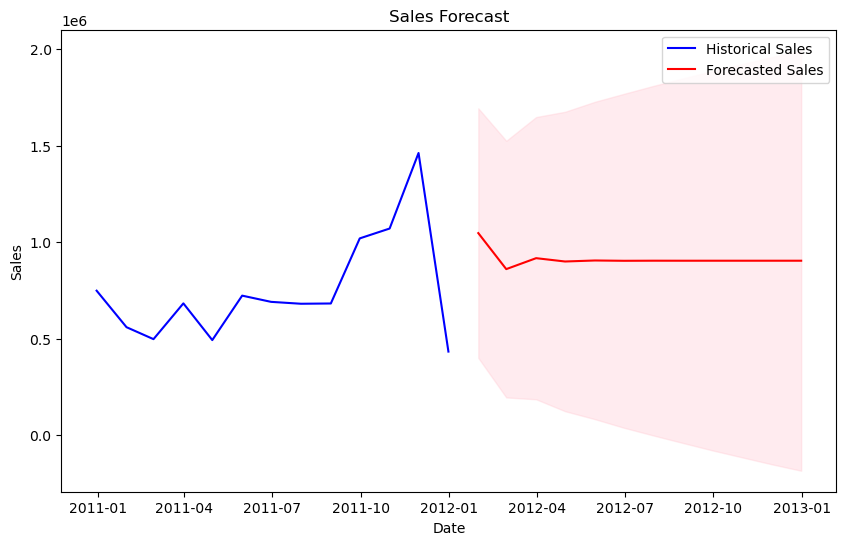

Forecasted Sales Values:
2012-01-31    1.047047e+06
2012-02-29    8.606053e+05
2012-03-31    9.172759e+05
2012-04-30    9.000504e+05
2012-05-31    9.052862e+05
2012-06-30    9.036947e+05
2012-07-31    9.041785e+05
2012-08-31    9.040314e+05
2012-09-30    9.040761e+05
2012-10-31    9.040625e+05
2012-11-30    9.040667e+05
2012-12-31    9.040654e+05
Freq: M, Name: predicted_mean, dtype: float64

Confidence Intervals for Forecasted Sales:
              lower Sales   upper Sales
2012-01-31  401027.430251  1.693067e+06
2012-02-29  196317.721193  1.524893e+06
2012-03-31  186711.020410  1.647841e+06
2012-04-30  125047.511396  1.675053e+06
2012-05-31   83786.465011  1.726786e+06
2012-06-30   39503.461434  1.767886e+06
2012-07-31   -1071.121748  1.809428e+06
2012-08-31  -40382.872145  1.848446e+06
2012-09-30  -77974.456205  1.886127e+06
2012-10-31 -114224.763895  1.922350e+06
2012-11-30 -149214.196405  1.957348e+06
2012-12-31 -183082.390753  1.991213e+06


In [22]:
# Forecast future sales for the next 12 months (or however many steps you want)
forecast_steps = 12  # Adjust this based on how far you want to forecast
forecast = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label='Historical Sales', color='blue')
plt.plot(pd.date_range(monthly_sales.index[-1], periods=forecast_steps + 1, freq='M')[1:], forecast_values, label='Forecasted Sales', color='red')
plt.fill_between(pd.date_range(monthly_sales.index[-1], periods=forecast_steps + 1, freq='M')[1:], 
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(loc='best')
plt.show()

# Print the forecasted values
print("Forecasted Sales Values:")
print(forecast_values)

# Print the confidence intervals for the forecasted values
print("\nConfidence Intervals for Forecasted Sales:")
print(conf_int)

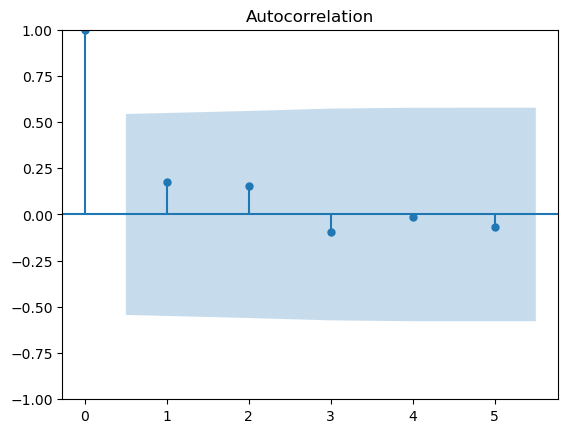

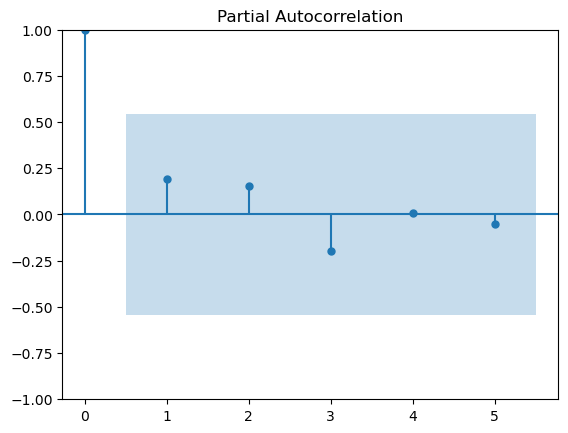

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF plots to help determine the order (p, q)
plot_acf(monthly_sales, lags=5)  # Set lags to a value based on your dataset
plot_pacf(monthly_sales, lags=5)
plt.show()

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Specify the seasonal order based on your ACF/PACF analysis
p, d, q = 1, 1, 1  # Adjust based on ACF/PACF
P, D, Q, m = 1, 1, 1, 12  # Adjust the seasonal components

# Define and fit the SARIMA model
sarima_model = SARIMAX(monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_model_fit = sarima_model.fit()

# Check the model summary
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   13
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 07 Nov 2024   AIC                             10.000
Time:                                    11:20:24   BIC                               -inf
Sample:                                12-31-2010   HQIC                               nan
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0        nan        nan        nan         nan         nan
ma.L1               0        nan   

C:\Users\dashp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dashp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dashp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: divide by zero encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\dashp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\dashp\anaconda3\lib\site-packages\statsmodels\tools